In [ ]:
# Install Plotly
!pip install Plotly==4.12

# Install Dash
!pip install dash
!pip install dash-html-components
!pip install dash-core-components
!pip install dash-table

In [ ]:
import os.path
import sys, json
import requests
import subprocess

import numpy as np
import pandas as pd
import plotly.express as px

from requests.exceptions import RequestException
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

from collections import namedtuple

In [ ]:
def download_ngrok():
    if not os.path.isfile('ngrok'):
        !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
        !unzip -o ngrok-stable-linux-amd64.zip
    pass

In [ ]:
Response = namedtuple('Response', ['url', 'error'])

def get_tunnel():
    try:
        Tunnel = subprocess.Popen(['./ngrok','http','8050'])

        session = requests.Session()
        retry = Retry(connect=3, backoff_factor=0.5)
        adapter = HTTPAdapter(max_retries=retry)
        session.mount('http://', adapter)

        res = session.get('http://localhost:4040/api/tunnels')
        res.raise_for_status()

        tunnel_str = res.text
        tunnel_cfg = json.loads(tunnel_str)
        tunnel_url = tunnel_cfg['tunnels'][0]['public_url']

        return Response(url=tunnel_url, error=None)
    except RequestException as e:
        return Response(url=None, error=str(e))

In [ ]:
# read datasets
df_confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
df_deaths= pd.read_csv('time_series_covid19_deaths_global.csv')

In [ ]:
df_deaths.head()

Province/State Country/Region       Lat  ...  11/18/20  11/19/20  11/20/20
0            NaN    Afghanistan  33.93911  ...      1645      1650      1661
1            NaN        Albania  41.15330  ...       646       657       672
2            NaN        Algeria  28.03390  ...      2206      2224      2236
3            NaN        Andorra  42.50630  ...        76        76        76
4            NaN         Angola -11.20270  ...       332       333       334

[5 rows x 308 columns]

In [ ]:
#Save dates
dates = df_deaths.columns[4:]

#Reshape datas
new_df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

new_df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

In [ ]:
new_df_deaths.head()

Province/State Country/Region       Lat       Long     Date  Deaths
0            NaN    Afghanistan  33.93911  67.709953  1/22/20       0
1            NaN        Albania  41.15330  20.168300  1/22/20       0
2            NaN        Algeria  28.03390   1.659600  1/22/20       0
3            NaN        Andorra  42.50630   1.521800  1/22/20       0
4            NaN         Angola -11.20270  17.873900  1/22/20       0

In [ ]:
#Merge dataframes
df_all = pd.merge(left=new_df_deaths, right=new_df_confirmed, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])

df_all['Province/State'] = df_all['Province/State'].fillna('')
df_all['Date'] = pd.to_datetime(df_all['Date'], format = '%x')

df_all.head()

Province/State Country/Region       Lat  ...       Date Deaths  Confirmed
0                   Afghanistan  33.93911  ... 2020-01-22      0          0
1                       Albania  41.15330  ... 2020-01-22      0          0
2                       Algeria  28.03390  ... 2020-01-22      0          0
3                       Andorra  42.50630  ... 2020-01-22      0          0
4                        Angola -11.20270  ... 2020-01-22      0          0

[5 rows x 7 columns]

In [ ]:
df_all.index = df_all.Date
df_all.head()

Province/State Country/Region  ...  Deaths  Confirmed
Date                                      ...                   
2020-01-22                   Afghanistan  ...       0          0
2020-01-22                       Albania  ...       0          0
2020-01-22                       Algeria  ...       0          0
2020-01-22                       Andorra  ...       0          0
2020-01-22                        Angola  ...       0          0

[5 rows x 7 columns]

In [ ]:
# Plot line graph here
fig = px.bar(df_all, 
                   x='Date',
                   y='Deaths',
                   color='Country/Region', 
                   title='Deaths by Covid-19 World')

# Overlay both histograms
fig.update_layout(barmode='overlay',
                  title_font_size=30)

fig.show()

In [ ]:
df_all['Date'] = df_all['Date'].apply(str)
fig = px.scatter_mapbox(df_all, 
                        lat='Lat', 
                        lon='Long', 
                        #text='Country/Region',
                        size='Deaths',
                        color='Deaths',
                        zoom=1, 
                        size_max=60,
                        animation_frame='Date',
                        animation_group='Country/Region',
                        hover_name='Country/Region',
                        hover_data = ['Confirmed', 'Deaths'],
                        title='World Map - Deaths by Covid-19 20/11/2020',
                        mapbox_style='carto-positron')

fig.update_layout(margin={'r':8,'t':24,'l':8,'b':4})

fig.show()
fig.write_html("deaths.html")

In [ ]:
%%writefile my_dash_app.py
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import pandas as pd


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

#put the role code of pre-processing and data cleaning here!!!

fig = px.scatter_mapbox(df_all, 
                        lat='Lat', 
                        lon='Long', 
                        text='Country/Region',
                        size='Deaths',
                        color='Deaths',
                        zoom=1, 
                        #animation_frame='Date',
                        #animation_group='Country/Region',
                        hover_name='Country/Region',
                        #title='Deaths by Covid-19 World',
                        mapbox_style='carto-positron')

fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0})

app.layout = html.Div([
    dcc.Graph(
        id='life-exp-vs-gdp',
        figure=fig
    )
])

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Overwriting my_dash_app.py


In [ ]:
download_ngrok()

In [ ]:
retorno = get_tunnel()
print(retorno)
!python my_dash_app.py

Response(url='https://e19b34492e28.ngrok.io', error=None)
Traceback (most recent call last):
  File "my_dash_app.py", line 12, in <module>
    fig = px.scatter_mapbox(df_all, 
NameError: name 'df_all' is not defined


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data_EU = df_all.groupby(by=['Date',"Country/Region"]).mean().unstack()["Deaths"][['Italy','Spain']].copy()

data_EU.tail()

Country/Region         Italy    Spain
Date                                 
2020-11-16 00:00:00  45733.0  41253.0
2020-11-17 00:00:00  46464.0  41688.0
2020-11-18 00:00:00  47217.0  42039.0
2020-11-19 00:00:00  47870.0  42291.0
2020-11-20 00:00:00  48569.0  42619.0

In [ ]:
plt.style.use('fivethirtyeight')

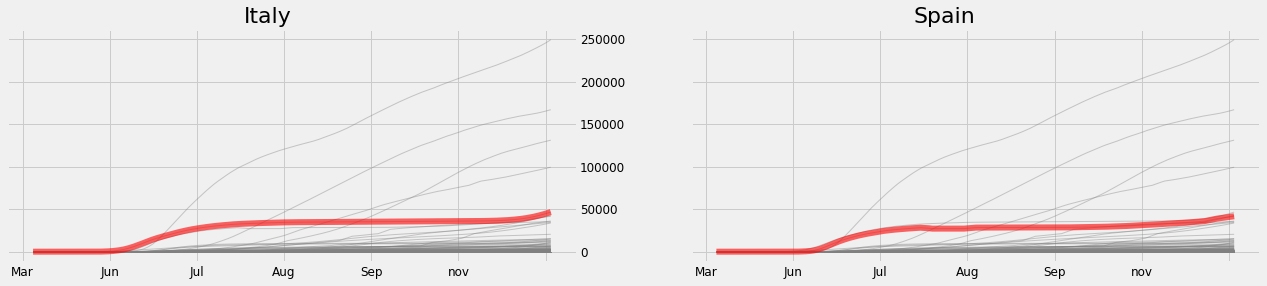

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,4))

item = "Deaths" 
countrys = ['Italy','Spain']

for i,country in enumerate(countrys):
  df_all.groupby(by=['Date',"Country/Region"]).mean().unstack()[item].rolling(window=7).mean().plot(legend=False,color="grey",linewidth=1, alpha=0.4, ax=ax[i])
  df_all.groupby(by=['Date','Country/Region']).mean().unstack()[item][country].rolling(window=7).mean().plot(legend=False,color="red",linewidth=6, alpha=0.6, ax=ax[i])
  ax[i].set_title(country,fontsize=22,ha='right')
  #ax[i].xaxis.grid(False)
  ax[i].set_xlabel("")
  
  ax[i].set_xticklabels(["","Mar","Jun","Jul","Aug","Sep","nov"])
  ax[i].xaxis.set_tick_params(labelsize=12)
  ax[i].yaxis.set_tick_params(labelsize=12)

  if (i==0) or (i==2):
    ax[i].yaxis.tick_right()
  else:
    ax[i].set_yticklabels([])

plt.savefig("EU.png",dpi=300)
plt.show()